In [1]:
import sys 
sys.path.append('../')

import numpy as np 
import itertools 
import scipy

from core.ranking_utils import * 
from core.pse import pseudo_embedding
from core.tensor_label_model_pse import TensorLabelModelPSE
from core.exp_label_model import * 
from core.pse import pseudo_embedding 

In [2]:
import pandas as pd 
df = pd.read_csv('../data/game_of_24.csv')
df.head()

,Rank,Puzzles,AMT (s),Solved rate,1-sigma Mean (s),1-sigma STD (s)
0,1,1 1 4 6,4.40,99.20%,4.67,1.48
1,2,1 1 11 11,4.41,99.60%,4.68,1.45
2,3,1 1 3 8,4.45,99.20%,4.69,1.48
3,4,1 1 1 8,4.48,98.80%,4.66,1.25
4,5,6 6 6 6,4.59,99.40%,4.82,1.49


In [ ]:
from expressions_utils import * 

lst_T = generate_all_trees()

In [4]:
def solve(n1,n2,n3,n4):
    for expr in lst_T:
        lst_evals, lst_perms = eval_exp_permute(expr,n1,n2,n3,n4)
        lst_evals = [int(x) for x in lst_evals]
        try:
            i = lst_evals.index(24)
            return expr, lst_perms[i]
        except:
            pass 
    return None, None 

In [5]:
lst_sol_expr = []
lst_sol_perm = []
lst_sol_perm_idcs = []
lst_nums = [ ]
for p in df['Puzzles']:
    nums = [int(x) for x in p.split(' ')]
    lst_nums.append(nums)
    ans_exp,ans_perm = solve(nums[0],nums[1],nums[2],nums[3])
    #print(ans_exp,ans_perm)
    lst_sol_expr.append(ans_exp)
    lst_sol_perm.append(list(ans_perm))
    for idcs_order in itertools.permutations(list(range(4))):
        num_order = [nums[u] for u in idcs_order]
        if(num_order==list(ans_perm)):
            lst_sol_perm_idcs.append(list(idcs_order))
            break 
    #lst_sol_perm.append(f"n1 = {ans_perm[0]}, n2 = {ans_perm[1]}, n3 = {ans_perm[2]}, n4 = {ans_perm[3]}")

    if(ans_exp is None):
        print(nums)
df['Solutions Expr'] = lst_sol_expr 
df['Solutions Perm Nums'] = lst_sol_perm
df['Solutions Perm Idcs'] = lst_sol_perm_idcs #[Ranking([0,1,2,3])]*len(df)


In [6]:
df.head()

,Rank,Puzzles,AMT (s),Solved rate,1-sigma Mean (s),1-sigma STD (s),Solutions Expr,Solutions Perm Nums,Solutions Perm Idcs
0,1,1 1 4 6,4.40,99.20%,4.67,1.48,( ( ( n1 + n2 ) - n3 ) x n4 ),"[1, 4, 1, 6]","[0, 2, 1, 3]"
1,2,1 1 11 11,4.41,99.60%,4.68,1.45,( ( n1 + n2 ) + ( n3 + n4 ) ),"[1, 1, 11, 11]","[0, 1, 2, 3]"
2,3,1 1 3 8,4.45,99.20%,4.69,1.48,( ( ( n1 + n2 ) - n3 ) x n4 ),"[1, 3, 1, 8]","[0, 2, 1, 3]"
3,4,1 1 1 8,4.48,98.80%,4.66,1.25,( ( ( n1 + n2 ) + n3 ) x n4 ),"[1, 1, 1, 8]","[0, 1, 2, 3]"
4,5,6 6 6 6,4.59,99.40%,4.82,1.49,( ( n1 + n2 ) + ( n3 + n4 ) ),"[6, 6, 6, 6]","[0, 1, 2, 3]"


In [ ]:
from core.exp_label_model import * 
from core.pse import pseudo_embedding 
from core.tensor_label_model_euclidean import TensorLabelModelEuclidean

np.set_printoptions(precision=8)

def dist_fun_0_1(y_1,y_2):
    return int(y_1 != y_2)


def get_dist_acc(Y_hat,Y,D2):
    return np.mean([D2[y][y_hat] for y,y_hat in zip(Y,Y_hat)])


def run_tensor_lm_1_hot(L,Y,k,D_squared,abstain_allowed=False):
    
    Y_emb_unique = np.eye(k)[[np.arange(k)]].squeeze()

    print(Y_emb_unique.shape)
    L_emb =[[Y_emb_unique[l,:] for l in L_i] for L_i in L]
    L_emb = np.array(L_emb)
    L_emb.shape 
    tlm = TensorLabelModelEuclidean(k,Y_emb_unique)
    tlm.k = k
    
    tlm.mu_recovery(L_emb,Y_emb_unique,0,1,2)
    
    Y_hat = tlm.predict(L_emb,abstain_allowed)
 
    return Y_hat

def run_mv(L,Y,D_squared):
    Y_hat  = scipy.stats.mode(L, axis=0)[0].squeeze()
    return Y_hat 

def run_tensor_lm_pse(L,Y,D_squared,k,dim=3):

    Y_emb_unique, tk = pseudo_embedding(D_squared, dim)
    Y_emb_unique = Y_emb_unique#*1000000

    L_emb =[[Y_emb_unique[l,:] for l in L_i] for L_i in L]
    L_emb = np.array(L_emb)
    #print(L_emb)
    L_emb.shape

    tlm = TensorLabelModelPSE(k,Y_emb_unique,tk)
    tlm.k = k
    tlm.mu_recovery(L_emb,0,1,2)

    Y_hat = tlm.predict(L_emb)
    
    return Y_hat 

#run_tensor_lm_1_hot(L,y_centers,k)

D_exp_tree_1 = compute_distances(lst_T,13,7,4,2) # 40%
D_exp_tree_2 = compute_distances(lst_T,13,8,9,1) # 50%
D_exp_tree_3 = compute_distances(lst_T,12,8,2,3) # %


D_exp_tree = D_exp_tree_1


D_tree_squared = D_exp_tree*D_exp_tree
k_tree = len(lst_T)
space_tree= np.arange(0,k_tree,1)

dict_tree = dict(zip(lst_T,list(range(k_tree))))
Y_tree = np.array([dict_tree[t] for t in df['Solutions Expr']])  


lst_unq_rankings = [ Ranking(list(x)) for x in itertools.permutations(list(range(4)))]
r_utils =  RankingUtils(4)
D_rankings = r_utils.get_pair_wise_dists(lst_unq_rankings)
D_rankings_squared = D_rankings*D_rankings

k_rankings = len(lst_unq_rankings)
space_rankings= np.arange(0,k_rankings,1)

dict_rankings = dict(zip([str(r) for r in lst_unq_rankings],list(range(k_rankings))))
Y_rankings = np.array([dict_rankings[str(r)] for r in df['Solutions Perm Idcs']])   

def sample_chains(theta):
        
    exp_model_tree = ExponentialLabelModel()
    P_tree = exp_model_tree.get_probability_table_true(space_tree, theta, D_tree_squared)

    L_tree = exp_model_tree.draw_samples(Y_tree)
    L_tree = np.array(L_tree)
    L_tree = L_tree.squeeze()

    exp_model_ranking = ExponentialLabelModel()
    P_ranking = exp_model_ranking.get_probability_table_true(space_rankings, theta, D_rankings_squared)

    L_rankings = exp_model_ranking.draw_samples(Y_rankings)
    L_rankings = np.array(L_rankings)
    L_rankings = L_rankings.squeeze()

    return L_tree, L_rankings

def get_accuracy_24(rec_exp,rec_perm_nums):
    c = 0
    s = 0
    N = len(rec_perm_nums)
    for i in range(N):
        nums = rec_perm_nums[i]
        z = eval_exp(rec_exp[i],nums[0],nums[1],nums[2],nums[3])
        #print(z)
        if(abs(z-24)<=1e-1):
            c+=1
        s+= abs(z-24)
        
    return c/N 


def recover_expression(Y_hat_rankings, Y_hat_tree):
    lst_ans = [(lst_T[Y_hat_tree[i]],Y_hat_rankings[i]) for i in range(len(Y_hat_tree)) ]
    return lst_ans 


def run(theta, seed):
    np.random.seed(seed)
    random.seed(seed)
    
    L_tree, L_rankings   = sample_chains(theta)
    k = len(lst_T)
    
    #acc_1_hot = run_tensor_lm_1_hot(L,Y,k,D)
    acc_1_hot = 0
    Y_hat_pse_tree =  run_tensor_lm_pse(L_tree,Y_tree,D_tree_squared,k,dim=50)

    #acc_1_hot = run_tensor_lm_1_hot(L,Y,k,D)
    acc_1_hot = 0
    Y_hat_pse_rankings =  run_tensor_lm_pse(L_rankings,Y_rankings,D_rankings_squared,k_rankings,dim=16)


    N = len(df)
    rec_exp_pse = [lst_T[t] for t in Y_hat_pse_tree]
    rec_perm_idcs_pse  = [lst_unq_rankings[t] for t in Y_hat_pse_rankings]
    rec_perm_nums_pse = [ [ lst_nums[i][u] for u in rec_perm_idcs_pse[i]] for i in range(N)]

    print(get_dist_acc(Y_hat_pse_tree,Y_tree,D_tree_squared))
    print(get_dist_acc(Y_hat_pse_tree,Y_tree,np.eye(k_tree)))

    print(get_dist_acc(Y_hat_pse_rankings,Y_rankings,D_rankings_squared))
    print(get_dist_acc(Y_hat_pse_rankings,Y_rankings,np.eye(k_rankings)))
    
    Y_hat_mv_tree = run_mv(L_tree,Y_tree,D_tree_squared)
    Y_hat_mv_rankings = run_mv(L_rankings,Y_rankings,D_rankings_squared)

    rec_exp_mv = [lst_T[t] for t in Y_hat_mv_tree]
    rec_perm_idcs_mv  = [lst_unq_rankings[t] for t in Y_hat_mv_rankings]
    rec_perm_nums_mv = [ [ lst_nums[i][u] for u in rec_perm_idcs_mv[i]] for i in range(N)]

    acc_pse = get_accuracy_24(rec_exp_pse,rec_perm_nums_pse)
    acc_mv = get_accuracy_24(rec_exp_mv,rec_perm_nums_mv)
    return acc_mv,acc_pse 




In [10]:
import pickle 

def run_trials(theta,T):
    lst_outs_mv = []
    lst_outs_pse = []
    for t in range(10):
        acc_mv, acc_pse = run(theta,t)
        print(acc_mv,acc_pse)
        lst_outs_mv.append(acc_mv)
        lst_outs_pse.append(acc_pse)

    th_str = '_'.join([str(x) for x in theta])
    pickle.dump({'lst_outs_mv':lst_outs_mv,'lst_outs_pse':lst_outs_pse},open(f'../outputs/theta_{th_str}.pkl','wb'))



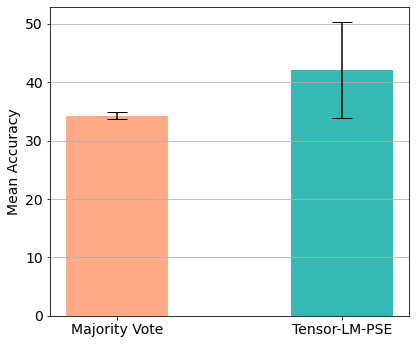

In [16]:
import matplotlib.pyplot as plt 
import matplotlib 
matplotlib.rcParams.update({'font.size': 14})

theta = [5.0, 0.6, 0.5]

run_trials(theta,10)

th_str = '_'.join([str(x) for x in theta])
o = pickle.load(open(f'../outputs/theta_{th_str}.pkl','rb'))

lst_outs_mv = o['lst_outs_mv']
lst_outs_pse = o['lst_outs_pse']

lst_outs_mv_np = np.array(lst_outs_mv)*100
lst_outs_pse_np = np.array(lst_outs_pse)*100
mv_mean  = np.mean(lst_outs_mv_np)
pse_mean = np.mean(lst_outs_pse_np) 

mv_std = np.std(lst_outs_mv_np)
pse_std = np.std(lst_outs_pse_np)

# Create lists for the plot
labels = ['Majority Vote', 'Tensor-LM-PSE']
x_pos = np.arange(len(labels))
means = [mv_mean, pse_mean]
error = [mv_std, pse_std]


fig, ax = plt.subplots(figsize=(6,5))
ax.bar(x_pos, means, yerr=error, align='center', alpha=0.9, ecolor='black', capsize=10,  color=['lightsalmon', 'lightseagreen'],width=[0.45,0.45])
ax.set_ylabel('Mean Accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)

ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('../plots/bar_plot_with_error_bars.png',dpi=200)
plt.show()